# PyTorch

In [11]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

## Dataset loading

In [12]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [13]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


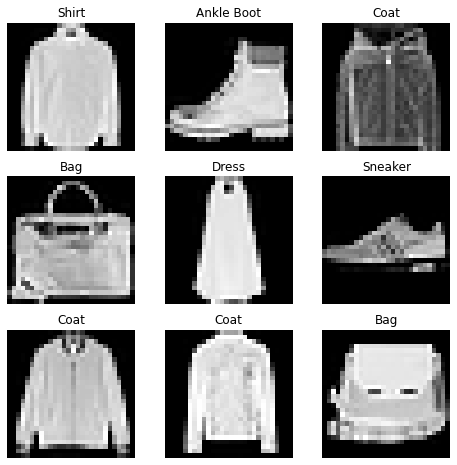

In [14]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Creating models

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device} device')

using cpu device


In [20]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28* 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [21]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Optimizing parameters

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [24]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')

In [25]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches =len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f'Test error: \n Accurzce: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')
    

In [26]:
epochs = 5
for epoch in range(epochs):
    print(f'Epoch {epoch+1}\n-------------------------------')
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print('Done')

Epoch 1
-------------------------------
loss: 2.315659 [    0/60000]
loss: 2.293895 [ 6400/60000]
loss: 2.277028 [12800/60000]
loss: 2.258113 [19200/60000]
loss: 2.248940 [25600/60000]
loss: 2.225475 [32000/60000]
loss: 2.220822 [38400/60000]
loss: 2.191119 [44800/60000]
loss: 2.192924 [51200/60000]
loss: 2.154179 [57600/60000]
Test error: 
 Accurzce: 55.6%, Avg loss: 2.153553 

Epoch 2
-------------------------------
loss: 2.174695 [    0/60000]
loss: 2.158875 [ 6400/60000]
loss: 2.098658 [12800/60000]
loss: 2.099109 [19200/60000]
loss: 2.054038 [25600/60000]
loss: 1.999211 [32000/60000]
loss: 2.014181 [38400/60000]
loss: 1.934564 [44800/60000]
loss: 1.946958 [51200/60000]
loss: 1.859681 [57600/60000]
Test error: 
 Accurzce: 53.9%, Avg loss: 1.867682 

Epoch 3
-------------------------------
loss: 1.908609 [    0/60000]
loss: 1.875782 [ 6400/60000]
loss: 1.755314 [12800/60000]
loss: 1.784539 [19200/60000]
loss: 1.677304 [25600/60000]
loss: 1.638551 [32000/60000]
loss: 1.653378 [38400/

In [ ]:
!torch.save(model.state_dict(), 'model.pth')

In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load('model.pth'))

In [29]:
classes = list(labels_map.values())

model.eval()
X,y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(X)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: {predicted}, Actual: {actual}')

Predicted: Ankle Boot, Actual: Ankle Boot
